# Исследование Stackoverflow за 2008 год

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Установка-библиотек,-подключение-к-базе-данных" data-toc-modified-id="Установка-библиотек,-подключение-к-базе-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Установка библиотек, подключение к базе данных</a></span></li><li><span><a href="#Задание-1" data-toc-modified-id="Задание-1-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Задание 1</a></span></li><li><span><a href="#Задание-2" data-toc-modified-id="Задание-2-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Задание 2</a></span></li><li><span><a href="#Задание-3" data-toc-modified-id="Задание-3-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Задание 3</a></span></li><li><span><a href="#Задание-4" data-toc-modified-id="Задание-4-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Задание 4</a></span></li><li><span><a href="#Задание-5" data-toc-modified-id="Задание-5-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Задание 5</a></span></li><li><span><a href="#Задание-6" data-toc-modified-id="Задание-6-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Задание 6</a></span></li><li><span><a href="#Задание-7" data-toc-modified-id="Задание-7-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Задание 7</a></span></li><li><span><a href="#Задание-8" data-toc-modified-id="Задание-8-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Задание 8</a></span></li><li><span><a href="#Задание-9" data-toc-modified-id="Задание-9-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Задание 9</a></span></li><li><span><a href="#Задание-10" data-toc-modified-id="Задание-10-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Задание 10</a></span></li></ul></div>

## Описание проекта

В данном проекте проводится исследование сервиса вопросов и ответов о программировании Stackoverflow. Этот сервис напоминает социальную сеть: пользователи пишут посты, оставляют комментарии, ставят оценки.

**Основные задачи**:
- произвести подключение к базе данных
- ответить на 10 вопросов, в точности соответствуя техническим заданиям на каждом шаге
- сделать выводы, при необходимости визуализировать данные


**Описание данных**:      

Яндекс Практикумом предоставлена база данных Stackoverflow, где хранится информация о постах, написанных в 2008 году и информация об оценках этих постов за тот год и более позднее время. 

ER-диаграмма базы:

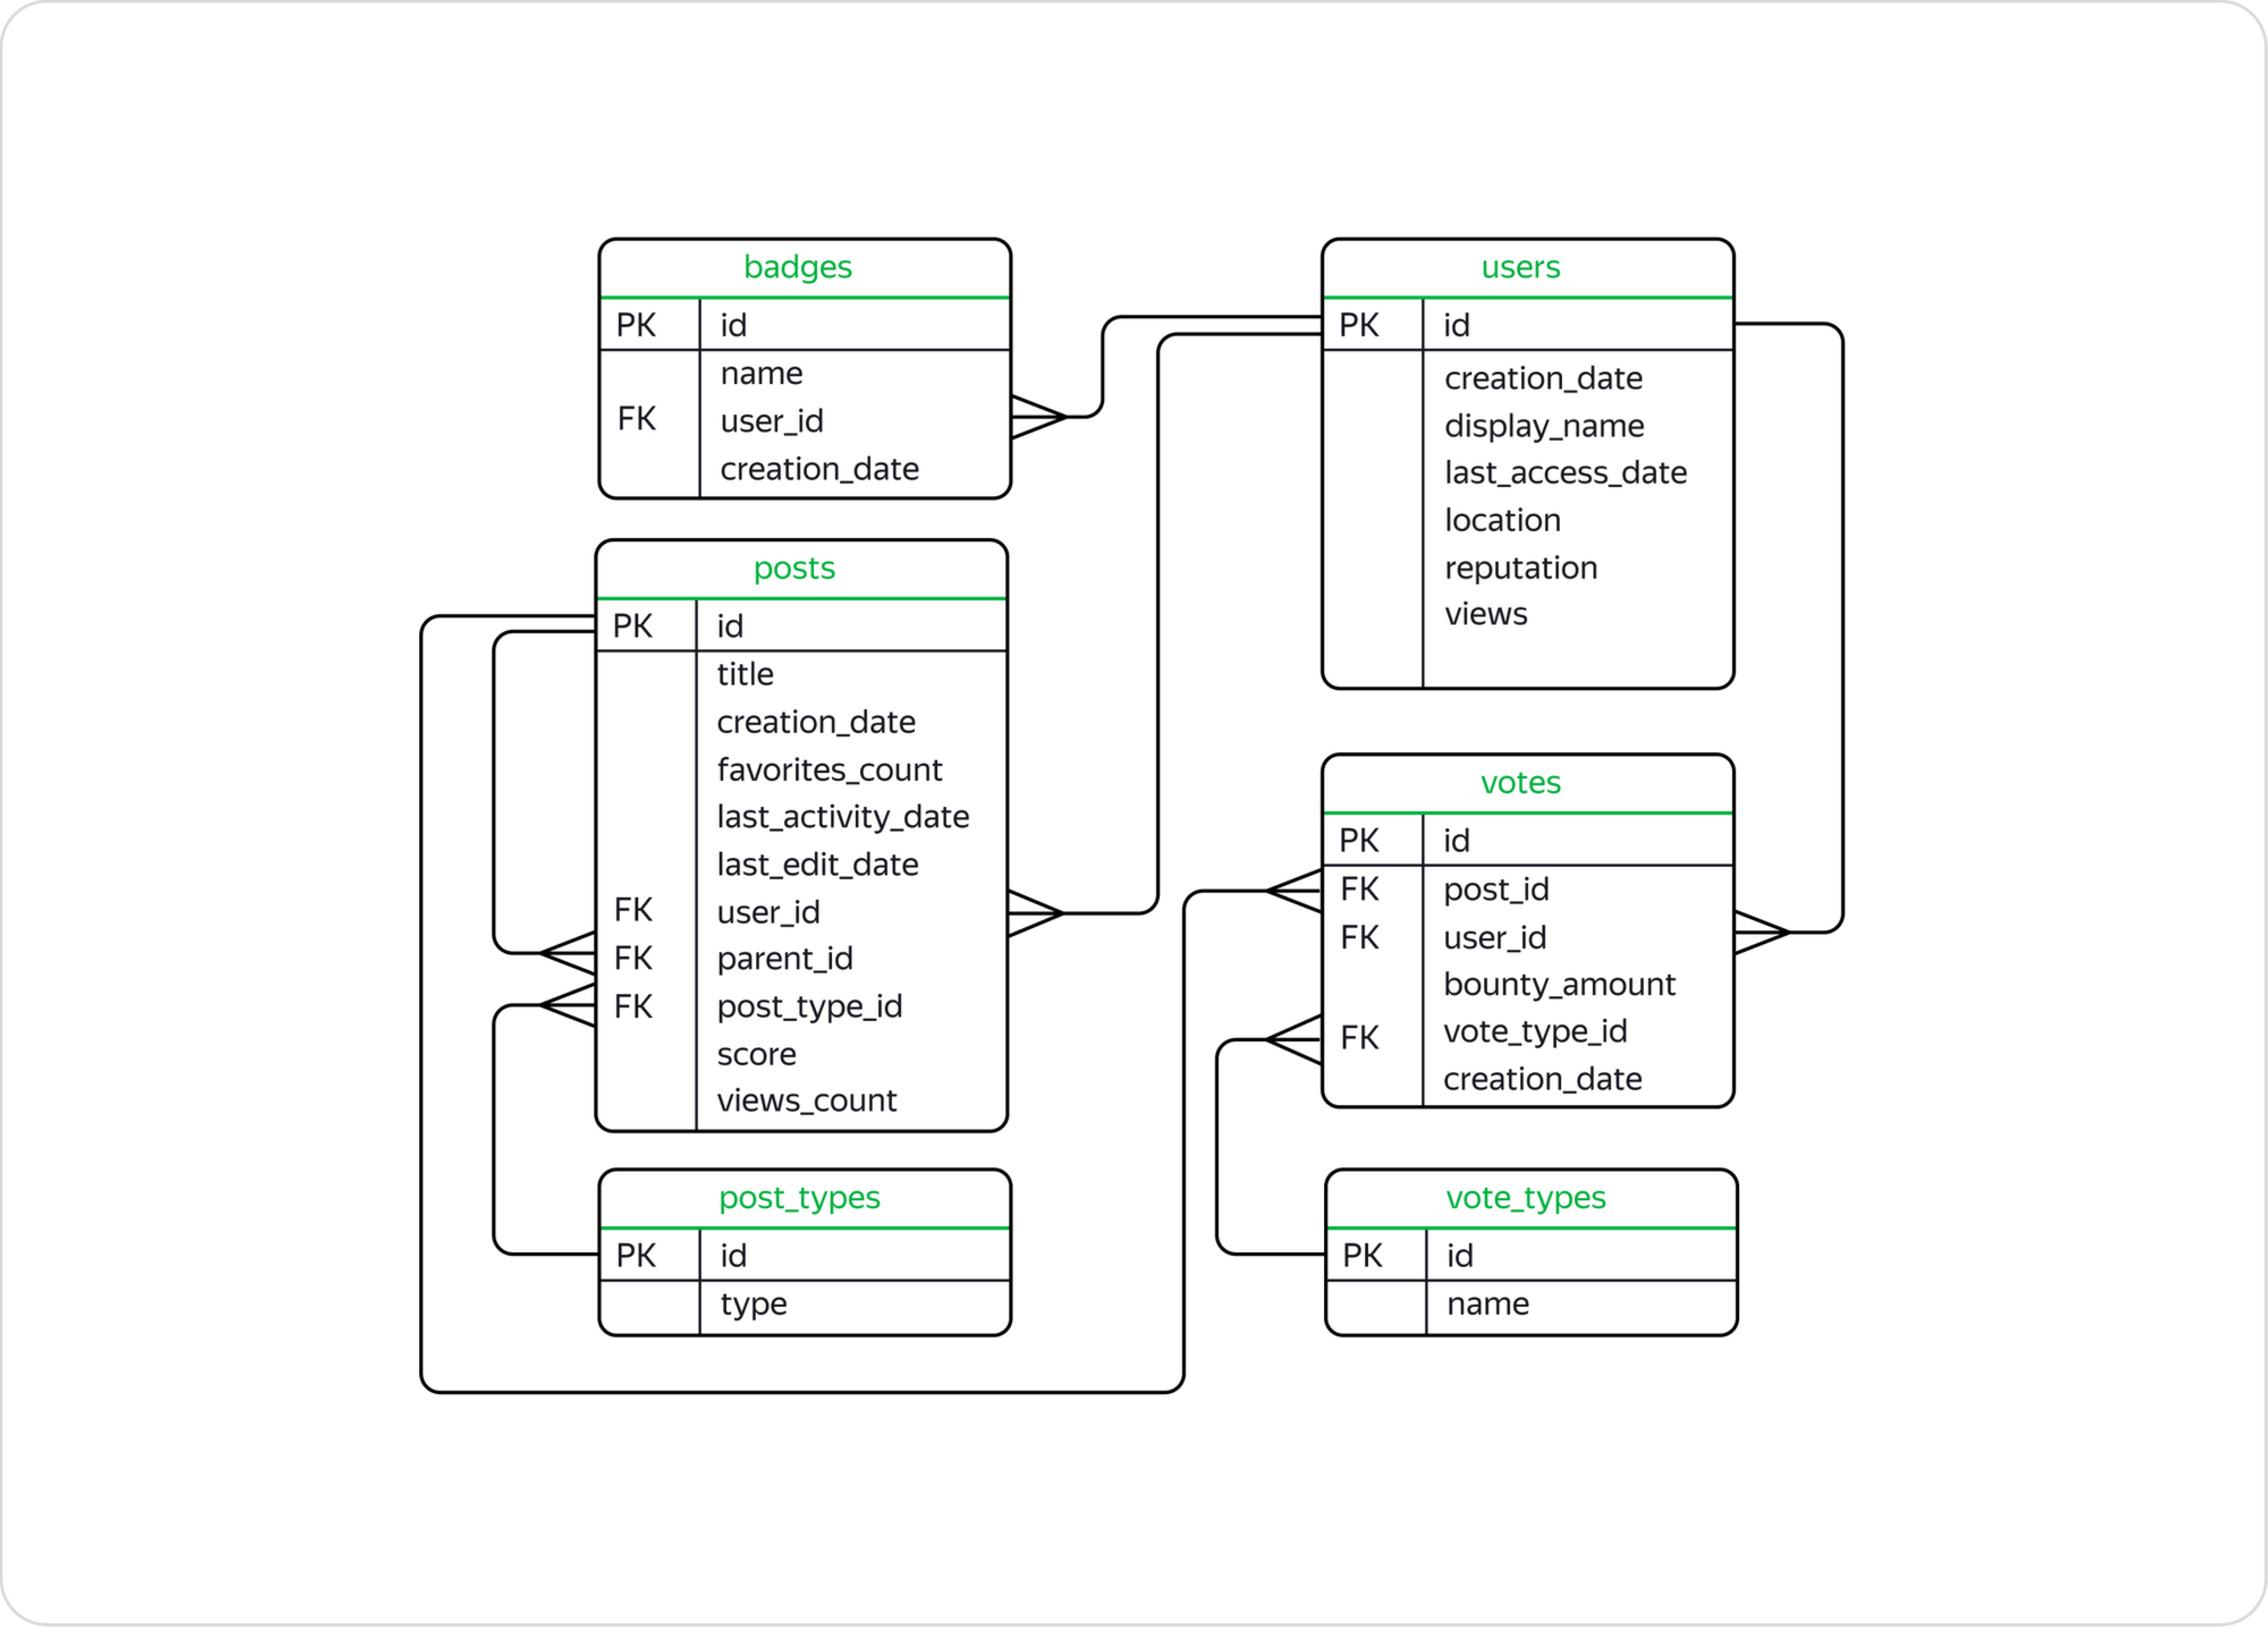

## Установка библиотек, подключение к базе данных 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения:

In [3]:
engine = create_engine(connection_string) 

Для удобства визуального восприятия больших чисел добавим пробелы:

In [4]:
class _IntArrayFormatter(pd.io.formats.format.GenericArrayFormatter):

    def _format_strings(self):
        formatter = self.formatter or (lambda x: ' {:,}'.format(x).replace(',', ' '))
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values

pd.io.formats.format.IntArrayFormatter = _IntArrayFormatter

## Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

In [5]:
query = '''
SELECT DISTINCT DATE_TRUNC('month', creation_date)::date AS month_date,
       SUM(views_count) OVER (PARTITION BY DATE_TRUNC('month', creation_date) ORDER BY DATE_TRUNC('month', creation_date)) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('year', creation_date) = '2008-01-01'
ORDER BY total_views DESC;
'''

df_1 = pd.read_sql_query(query, con=engine)
df_1

,month_date,total_views
0,2008-09-01,452 928 568
1,2008-10-01,365 400 138
2,2008-11-01,221 759 651
3,2008-12-01,197 792 841
4,2008-08-01,131 367 083
5,2008-07-01,669 895


Для удобства анализа расположим месяцы в хронологическом порядке и построим график:

In [7]:
query = '''
WITH a AS
(SELECT DISTINCT DATE_TRUNC('month', creation_date)::date AS month_date,
       SUM(views_count) OVER (PARTITION BY DATE_TRUNC('month', creation_date) ORDER BY DATE_TRUNC('month', creation_date)) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('year', creation_date) = '2008-01-01'
ORDER BY total_views DESC)

SELECT EXTRACT(MONTH FROM month_date)::integer AS month_date,
       total_views
FROM a
ORDER BY month_date;
'''

df_1_for_viz = pd.read_sql_query(query, con=engine)
df_1_for_viz

,month_date,total_views
0,7,669 895
1,8,131 367 083
2,9,452 928 568
3,10,365 400 138
4,11,221 759 651
5,12,197 792 841


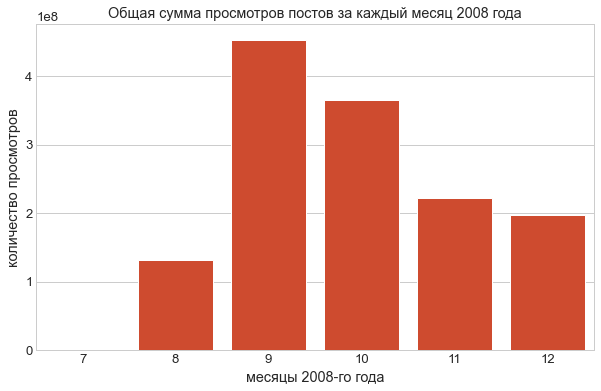

In [8]:
plt.figure(figsize = (10, 6))
sns.set(font_scale=1.2)
plt.style.use('seaborn-whitegrid')
sns.barplot(data=df_1_for_viz, x='month_date', y='total_views', color='#E83A14') #цвет в стиле Stackoverflow
plt.title('Общая сумма просмотров постов за каждый месяц 2008 года')
plt.xlabel('месяцы 2008-го года')
plt.ylabel('количество просмотров')
plt.show();

**Вывод**:

- при взгляде на график первой напрашивается мысль об отпусках летом: в июле все отдыхают, а к сентябрю включаются в активную работу (разработчики ведь тоже люди). То есть на ум приходит сезонный фактор. НО на самом деле это не так (по крайней мере это не основная причина), достаточно поискать информацию в интернете:

- Stackoverflow запустился в 2008 году и всплеск активности в сентябре связан с доработкой сайта, а не с сезонным фактором

Вот что пишет Джоэль Спольски: "Мы начали обсуждать способы сделать наш сайт крутым. Джефф начал работу над кодом в апреле 2008 года, привлек к проекту еще двух программистов (Джеффа и Джаррода, которые все еще в нашей компании), и втроем они смогли запустить махину под названием Stack Overflow в сентябре 2008 года". 

Источник: https://habr.com/ru/company/skillfactory/blog/506880/

## Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

Какие аномалии наблюдаются в данных? О чём они говорят?

In [9]:
query = '''
SELECT DISTINCT d.display_name,
       COUNT(DISTINCT(p.user_id))
FROM 
    (SELECT DISTINCT u.display_name,
            COUNT(p.id) AS cnt_posts
    FROM stackoverflow.users u
    JOIN stackoverflow.posts p ON u.id=p.user_id
    JOIN stackoverflow.post_types pt ON p.post_type_id=pt.id
    WHERE pt.type = 'Answer' AND p.creation_date::date BETWEEN u.creation_date::date AND u.creation_date::date + interval '1 month'
    GROUP BY 1
    HAVING COUNT(p.id) >100) d
JOIN stackoverflow.users u ON d.display_name=u.display_name
JOIN stackoverflow.posts p ON u.id=p.user_id
GROUP BY 1
ORDER BY display_name;
'''

df_2 = pd.read_sql_query(query, con=engine)
df_2

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,11
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


In [10]:
query = '''
SELECT DISTINCT d.display_name,
       COUNT(DISTINCT(p.user_id))
FROM 
    (SELECT DISTINCT u.display_name,
            COUNT(p.id) AS cnt_posts
    FROM stackoverflow.users u
    JOIN stackoverflow.posts p ON u.id=p.user_id
    JOIN stackoverflow.post_types pt ON p.post_type_id=pt.id
    WHERE pt.type = 'Answer' AND p.creation_date::date BETWEEN u.creation_date::date AND u.creation_date::date + interval '1 month'
    GROUP BY 1
    HAVING COUNT(p.id) >100) d
JOIN stackoverflow.users u ON d.display_name=u.display_name
JOIN stackoverflow.posts p ON u.id=p.user_id
GROUP BY 1
HAVING COUNT(DISTINCT(p.user_id)) >1
ORDER BY count DESC;
'''

df_2_for_viz = pd.read_sql_query(query, con=engine)

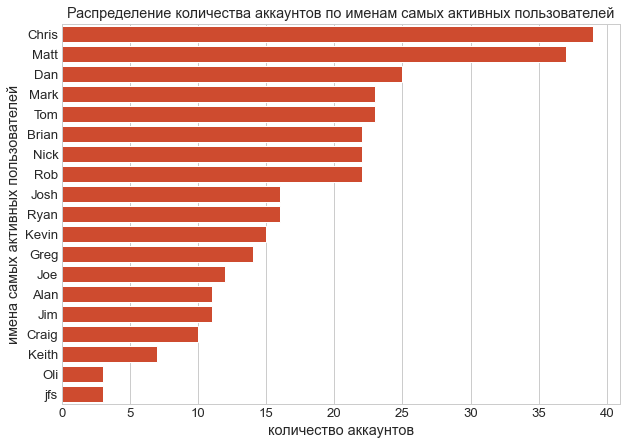

In [11]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
plt.style.use('seaborn-whitegrid')
sns.barplot(data=df_2_for_viz, x= 'count', y='display_name', color='#E83A14')
plt.title('Распределение количества аккаунтов по именам самых активных пользователей')
plt.xlabel('количество аккаунтов')
plt.ylabel('имена самых активных пользователей')
plt.show();

In [12]:
len(df_2.query('count ==1'))

60

In [13]:
len(df_2.query('count >1'))

19

**Вывод**:

В отобранных данных  мы видим аномалии: из 79 самых активных пользователей 60 имеют один аккаунт (т.е.user_id), а 19 - больше одного. На графике мы видим, что количество таких аккаунтов может измеряться несколькими десятками.

Мы отобрали самые популярные имена пользователей, но за этими именами могут находиться самые разные люди, каждый со своим user_id. Посмотрим на список этих самых популярных имён: Chris, Matt, Dan, Mark, Tom и т.д. - все эти имена пользователей содержат только само имя, без фамилии и каких-либо других дополнений. Возможно, мы видим список самых популярных имён среди разработчиков в 2008 году😊.

Эту проблему может решить ограничение при регистрации новых пользователей: нельзя занимать уже существующее имя. 

Возможно, причины этих аномалий появились ещё во время доработки сайта, а в настоящее время такой проблемы уже нет.

## Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

In [14]:
query = '''
SELECT DATE_TRUNC('month',p.creation_date)::date AS month,
       COUNT(p.id)
FROM 
    (SELECT u.id,
            COUNT(p.id) AS cnt
    FROM stackoverflow.users u
    JOIN stackoverflow.posts p ON u.id=p.user_id
    WHERE DATE_TRUNC('month',u.creation_date)::date='2008-09-01' AND DATE_TRUNC('month', p.creation_date)::date='2008-12-01'
    GROUP BY 1) u
JOIN stackoverflow.posts p ON u.id=p.user_id
WHERE cnt >=1
GROUP BY 1
ORDER BY 1 DESC;
'''

df_3 = pd.read_sql_query(query, con=engine)
df_3

,month,count
0,2008-12-01,17 641
1,2008-11-01,18 294
2,2008-10-01,27 171
3,2008-09-01,24 870
4,2008-08-01,32


**Вывод**:

По условию задания мы отбирали посты пользователей, зарегистрированных в сентябре 2008 года, однако у нас есть 32 поста от них в августе. Вероятно, это связано с обновлением и доработкой сайта, произошедшей как раз в сентябре 2008 года. Видимо, прежним пользователям пришлось регистрироваться заново в сентябре, поэтому дата их регистрации обновилась, а августовские посты остались.

## Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [15]:
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id;
'''

df_4 = pd.read_sql_query(query, con=engine)
df_4

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480 476,480 476
1,1,2008-07-31 23:55:38,136 033,616 509
2,1,2008-07-31 23:56:41,0,616 509
3,1,2008-08-04 02:45:08,0,616 509
4,1,2008-08-04 04:31:03,0,616 509
...,...,...,...,...
243 791,5 696 608,2008-12-23 16:00:37,0,2 804
243 792,5 696 608,2008-12-23 17:35:09,0,2 804
243 793,5 696 608,2008-12-24 01:02:48,0,2 804
243 794,5 696 608,2008-12-30 14:34:45,0,2 804


## Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [16]:
query = '''
WITH a AS
(SELECT user_id,
       COUNT(id)
FROM stackoverflow.posts
WHERE DATE_TRUNC('month', creation_date)::date = '2008-08-01'
GROUP BY 1
HAVING COUNT(id) >120),

b AS
(SELECT a.user_id,
       DATE_TRUNC('day', creation_date)::date,
       COUNT(id) AS cnt
FROM a
JOIN stackoverflow.posts p ON a.user_id=p.user_id
WHERE DATE_TRUNC('month', creation_date)::date = '2008-08-01'
GROUP BY 1,
         2)
         
SELECT user_id,
       AVG(cnt) AS avg_daily
FROM b
GROUP BY 1
ORDER BY 2;
'''

df_5 = pd.read_sql_query(query, con=engine)
df_5

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


## Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [17]:
query = '''
WITH a AS
(SELECT DISTINCT user_id,
       creation_date::date AS dt
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY 1,
         2),
b AS
(SELECT user_id,
        COUNT(DISTINCT(dt)) AS cnt_dt --вот здесь изменения (была оконная функция, а теперь просто DISTINCT)
FROM a
GROUP BY 1
ORDER BY user_id)

SELECT AVG(cnt_dt)::integer AS result
FROM b;

'''

df_6 = pd.read_sql_query(query, con=engine)
df_6

,result
0,2


Проанализируйте итоговую таблицу — какие выводы можно сделать?

**Вывод**:

Пользователи в период с 1 по 7 декабря в среднем взаимодействовали с платформой 2 дня.

## Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [18]:
query = '''
WITH a AS
(SELECT user_id,
       creation_date,
       LAG(DATE_TRUNC('month', creation_date)::date, 2) OVER (PARTITION BY user_id ORDER BY creation_date) AS last_month
FROM stackoverflow.posts
ORDER BY 1,
         2)
         
SELECT user_id,
       creation_date,
       TO_CHAR(last_month, 'Month') AS second_last_month
FROM a;
'''

df_7 = pd.read_sql_query(query, con=engine)
df_7

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243 791,5 696 608,2008-12-23 16:00:37,December
243 792,5 696 608,2008-12-23 17:35:09,December
243 793,5 696 608,2008-12-24 01:02:48,December
243 794,5 696 608,2008-12-30 14:34:45,December


## Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

In [19]:
query = '''
WITH profile AS
(SELECT user_id,
       MIN(DATE_TRUNC('month', creation_date)) AS cohort_dt,
       COUNT(*) OVER (PARTITION BY MIN(DATE_TRUNC('month', creation_date))) AS cohort_users_cnt
FROM stackoverflow.posts
GROUP BY 1),

sessions AS
(SELECT user_id,
        DATE_TRUNC('month', p.creation_date) AS session_date
FROM stackoverflow.posts p
GROUP BY 1,
         2)

SELECT cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) *100.0/cohort_users_cnt, 2) AS retention_rate
FROM profile p 
JOIN sessions s ON p.user_id=s.user_id
GROUP BY 1,
         2,
         4;
'''

df_8 = pd.read_sql_query(query, con=engine)
df_8

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2 151,2 151,100.00
7,2008-08-01,2008-09-01,1 571,2 151,73.04
8,2008-08-01,2008-10-01,1 275,2 151,59.27
9,2008-08-01,2008-11-01,1 050,2 151,48.81


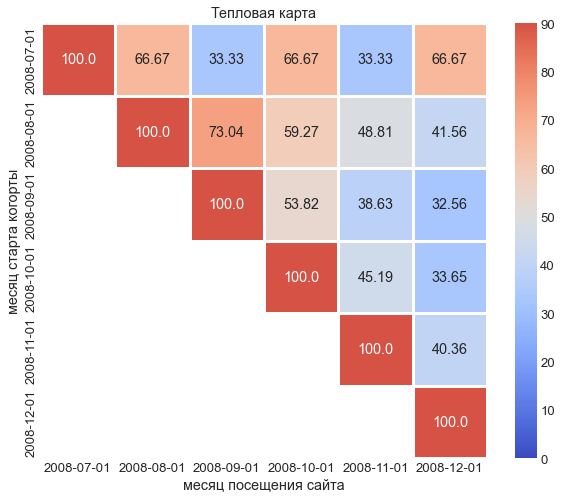

In [20]:
# создаём сводную таблицу с результатами
retention = df_8.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(10, 8))# задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='', # задаём исходный формат
            vmin=0, vmax=90, center= 50, cmap= 'coolwarm', linewidths=3,linecolor='white') # меняем дизайн
plt.title('Тепловая карта') 
plt.xlabel('месяц посещения сайта')
plt.ylabel('месяц старта когорты')
plt.show()

**Вывод**:

Наблюдения:
- самые высокие коэффициенты удержания первого месяца у июльской и августовской когорт (66.67 и 73.04), для каждой следующей когорты этот показатель постепенно снижается

- августовская когорта самая "удерживаемая" на протяжении всего времени

Аномалии:
- для июльской когорты представлена необычная картина: Retention Rate то высокий, то низкий, и эти скачки появляются несколько раз. Кроме самих скачков настораживают одинаковые цифры: то 66.67, то 33.33 (в сумме они дают 100). 

- если мы обратим внимание на саму таблицу, то увидим, что такая картина связана с небольшим количеством пользователей в этой когорте - их всего 3. И когда 1 из них что-то пишет, то коэффициент становится 33.33, а когда пишут двое пользователей из этих трёх - то 66.67. Таким образом, эта аномалия следствие малой выборки.

## Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

Постройте круговую диаграмму с количеством постов по месяцам.

In [21]:
query = '''
WITH a AS
(SELECT DISTINCT(EXTRACT(MONTH FROM creation_date))::integer AS creation_month,
       COUNT(id) AS posts_count
FROM stackoverflow.posts
WHERE DATE_TRUNC('month', creation_date)::date BETWEEN '2008-09-01' AND '2008-12-01'
GROUP BY 1),

b AS
(SELECT creation_month,
       posts_count,
       LAG(posts_count) OVER (ORDER BY creation_month) AS past
FROM a)

SELECT creation_month,
       posts_count,
       ROUND((posts_count - past)::numeric / past * 100, 2) AS percentage
FROM b;
'''

df_9 = pd.read_sql_query(query, con=engine)
df_9

,creation_month,posts_count,percentage
0,9,70 371,NaN
1,10,63 102,-10.33
2,11,46 975,-25.56
3,12,44 592,-5.07


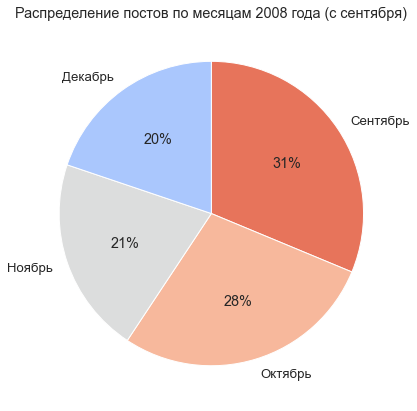

In [23]:
plt.figure(figsize=(7, 7))
palette_color = sns.color_palette('coolwarm_r', 5)
df_9['month'] = ['Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
x = df_9['posts_count']
labels = df_9['month']
plt.pie(x=x, labels=labels, autopct='%.0f%%', colors=palette_color, counterclock=False, startangle=90)
plt.title('Распределение постов по месяцам 2008 года (с сентября)')
plt.show();

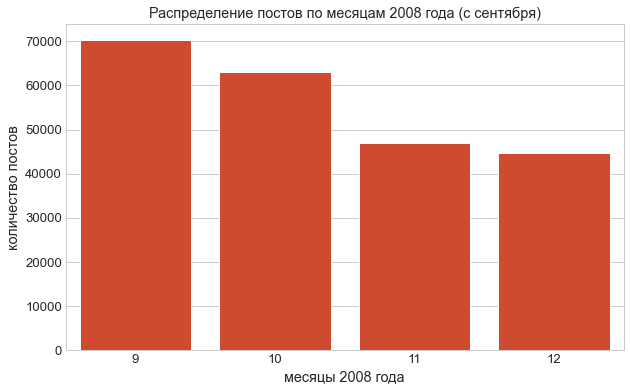

In [24]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df_9, x='creation_month', y='posts_count', color='#E83A14')
plt.title('Распределение постов по месяцам 2008 года (с сентября)')
plt.xlabel('месяцы 2008 года')
plt.ylabel('количество постов')
plt.show();

## Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [25]:
query = '''
WITH a AS
(SELECT DISTINCT user_id AS top_user,
       COUNT(id)
FROM stackoverflow.posts
GROUP BY 1
ORDER BY COUNT(id) DESC
LIMIT 1),

b AS
(SELECT EXTRACT(WEEK FROM creation_date) AS week_creation,
       creation_date
FROM a
JOIN stackoverflow.posts p ON a.top_user=p.user_id
WHERE DATE_TRUNC('month', creation_date)::date = '2008-10-01'
GROUP BY 2)

SELECT DISTINCT week_creation::integer,
       LAST_VALUE(creation_date) OVER (PARTITION BY week_creation ORDER BY creation_date ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) AS creation_date
FROM b
ORDER BY 1;
'''

df_10 = pd.read_sql_query(query, con=engine)
df_10

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
